# This notebook is used to determine the sensitivity matrix from CWFS data
### It first finds the pairs of CWFS images in the EFD
### It then fits the data a reports the zernikes
### Then plots the relationships and fits a slope for the matrix

In [1]:
import asyncio 
import matplotlib

import numpy as np
import pandas as pd

from matplotlib import pylab as plt
from astropy.time import Time, TimeDelta

from lsst_efd_client import EfdClient, resample

%matplotlib inline

In [2]:
# Temporarily needed to run at summit
import os
os.environ["LSST_DDS_DOMAIN"] = 'lsatmcs'
os.environ["OSPL_URI"] = "file:///home/patrickingraham/ospl.xml"

In [3]:
#efd_client = EfdClient('summit_efd')
efd_client = EfdClient('ncsa_efd') #summit_efd currently offline so need to use copy at NCSA

### Find CWFS pairs
Query for all the `endReadout` events on the timespan of the night.

In [4]:
t1 = Time("2020-02-19T05:35", format='isot', scale='tai')
t2 = Time("2020-02-19T11:18", format='isot', scale='tai')#+TimeDelta(8.*24.*60*60., format='sec', scale='tai')

In [5]:
end_readout = await efd_client.select_time_series("lsst.sal.ATCamera.logevent_endReadout", 
                                           ["imageName", "exposureTime", "groupId", "imageType"], t1, t2)

Now match each entry. For each `i` item with `intra` in the name, there must be an `i+1` with `extra` otherwise it is not a pair. 
A pair also has the same groupID

In [44]:
intra_images = []
extra_images = []
intra_times = []
extra_times = []
intra_exptimes = []
extra_exptimes = []

i = 0
npairs = 0
nmiss = 0

while i < len(end_readout)-2:
    intra = end_readout['imageName'][i]
    extra = end_readout['imageName'][i+1]
    
    #skip known bad files
    if intra == 'AT_O_20200218_000179' and extra == 'AT_O_20200218_000180':
        i+=2
        continue
    
    if ((end_readout['groupId'][i] == end_readout['groupId'][i+1]) and 
        (end_readout['groupId'][i+1] != end_readout['groupId'][i+2]) and
        (end_readout['imageType'][i] == 'ENGTEST')):
        
        print(f"Got a pair: {intra} x {extra}")
        intra_images.append(intra)
        extra_images.append(extra)
        intra_times.append(end_readout.index[i])
        extra_times.append(end_readout.index[i+1])
        intra_exptimes.append(end_readout['exposureTime'][i])
        extra_exptimes.append(end_readout['exposureTime'][i+1])
        i+=2
        npairs+=1
    else:
#         print(f"No Match: {intra} x {extra}")
        nmiss+=1
        i+=1

print(f"Got {npairs} pairs and {nmiss} misses.")

Got a pair: AT_O_20200218_000167 x AT_O_20200218_000168
Got a pair: AT_O_20200218_000169 x AT_O_20200218_000170
Got a pair: AT_O_20200218_000171 x AT_O_20200218_000172
Got a pair: AT_O_20200218_000173 x AT_O_20200218_000174
Got a pair: AT_O_20200218_000175 x AT_O_20200218_000176
Got a pair: AT_O_20200218_000177 x AT_O_20200218_000178
Got a pair: AT_O_20200218_000181 x AT_O_20200218_000182
Got a pair: AT_O_20200218_000184 x AT_O_20200218_000185
Got a pair: AT_O_20200218_000187 x AT_O_20200218_000188
Got a pair: AT_O_20200218_000190 x AT_O_20200218_000191
Got 10 pairs and 205 misses.


In [45]:
# Create numpy data structure to hold items of interest
match_data = np.zeros(npairs, dtype=[('intra', '<U35'), 
                                     ('extra', '<U35'), 
                                     ('az', float), 
                                           ('el', float), 
                                           ('rot_pos', float),
                                           ('x', float), 
                                           ('y', float), 
                                           ('z', float), 
                                           ('u', float), 
                                           ('v', float), 
                                           ('w', float), 
                                     ('m1_pressure', float),
                                     ('dz', float)])

In [46]:
# Populate the data structure from the pairs found above
for i in range(npairs):
    
    # Determine time stamps for searching for metadata
    # include ability to correct for TAI if required, but set to zero for the moment

    t1 = Time(intra_times[i], scale='tai') - TimeDelta(intra_exptimes[i], format='sec', scale='tai') 
    #- TimeDelta(180., format='sec', scale='tai')
    t2 = Time(extra_times[i], scale='tai') - TimeDelta(2., format='sec', scale='tai')

    azel = await efd_client.select_time_series("lsst.sal.ATMCS.mount_AzEl_Encoders", 
                                               ["elevationCalculatedAngle99", "azimuthCalculatedAngle99"], t1, t2)
    
    rotator = await efd_client.select_time_series("lsst.sal.ATMCS.mount_Nasmyth_Encoders",
                                                  ["nasmyth2CalculatedAngle99"], t1, t2)

    hexapod_vals = await efd_client.select_time_series("lsst.sal.ATHexapod.positionStatus", 
                                           ["reportedPosition0", "reportedPosition1", "reportedPosition2",
                                           "reportedPosition3", "reportedPosition4", "reportedPosition5"], t1 , t2)

    m1_pressure = await efd_client.select_time_series("lsst.sal.ATPneumatics.m1AirPressure",
                                                  ["pressure"], t1, t2)
    
    offset = await efd_client.select_time_series("lsst.sal.ATAOS.logevent_hexapodCorrectionCompleted",
                                                 ["hexapod_x", "hexapod_y", "hexapod_z", "hexapod_u", "hexapod_v", "hexapod_w"], t1, t2)
    
    rot_pos = np.mean(rotator['nasmyth2CalculatedAngle99'])
    el = np.mean(azel['elevationCalculatedAngle99'])
    az = np.mean(azel['azimuthCalculatedAngle99'])
    
    # Take median hexapod position over the time interval
    x = hexapod_vals['reportedPosition0'].median()
    y = hexapod_vals['reportedPosition1'].median()
    z = hexapod_vals['reportedPosition2'].median()
    u = hexapod_vals['reportedPosition3'].median()
    v = hexapod_vals['reportedPosition4'].median()
    w = hexapod_vals['reportedPosition5'].median()

    m1 = np.mean(m1_pressure['pressure'])
    dz = np.nan #round((offset['hexapod_z'][-1] - offset['hexapod_z'][-2])/2.,3)
    print(t1,t2,az, el, rot_pos, x, y, z, u, u, w,dz)
    match_data[i] = (f"{intra_images[i]}.fits", f"{extra_images[i]}.fits", az, el, rot_pos, x, y, z, u, u, w, m1, dz)


200: SELECT elevationCalculatedAngle99, azimuthCalculatedAngle99 FROM "efd"."autogen"."lsst.sal.ATMCS.mount_AzEl_Encoders" WHERE time >= '2020-02-19T05:38:09.134Z' AND time <= '2020-02-19T05:39:16.791Z'
200: SELECT nasmyth2CalculatedAngle99 FROM "efd"."autogen"."lsst.sal.ATMCS.mount_Nasmyth_Encoders" WHERE time >= '2020-02-19T05:38:09.134Z' AND time <= '2020-02-19T05:39:16.791Z'
200: SELECT reportedPosition0, reportedPosition1, reportedPosition2, reportedPosition3, reportedPosition4, reportedPosition5 FROM "efd"."autogen"."lsst.sal.ATHexapod.positionStatus" WHERE time >= '2020-02-19T05:38:09.134Z' AND time <= '2020-02-19T05:39:16.791Z'
200: SELECT pressure FROM "efd"."autogen"."lsst.sal.ATPneumatics.m1AirPressure" WHERE time >= '2020-02-19T05:38:09.134Z' AND time <= '2020-02-19T05:39:16.791Z'
200: SELECT hexapod_x, hexapod_y, hexapod_z, hexapod_u, hexapod_v, hexapod_w FROM "efd"."autogen"."lsst.sal.ATAOS.logevent_hexapodCorrectionCompleted" WHERE time >= '2020-02-19T05:38:09.134Z' AND 

In [47]:
# Convert to dataframe
df = pd.DataFrame(match_data)

In [48]:
# for i in range(len(df)):
#     print(f"{df['intra'][i]}: {df['el'][i]+df['rot_pos'][i]}: dz={df['dz'][i]}")
# # df['intra'],df['el']+df['rot_pos']

In [49]:
filename="20200123_match_sens_matrix_metadata.csv"
df.to_csv(filename)

# Now reduce the data for each pair to get the zernikes from fitting

In [50]:
# Requires new pandas version to use
# df2 = pd.DataFrame.read_csv("20200123_match.csv")

In [51]:
#df2 = pd.DataFrame.from_csv("20200123_match.csv")
df2 = pd.read_csv(filename)
# but need to add all the zernike terms from teh fitting
df2['zern_defocus_nm'] = np.zeros(len(df2))
df2['zern_xastig_nm'] = np.zeros(len(df2))
df2['zern_yastig_nm'] = np.zeros(len(df2))
df2['zern_xcoma_nm'] = np.zeros(len(df2))
df2['zern_ycoma_nm'] = np.zeros(len(df2))
df2['zern_xtrefoil_nm'] = np.zeros(len(df2))
df2['zern_ytrefoil_nm'] = np.zeros(len(df2))
df2['zern_sphereical_nm'] = np.zeros(len(df2))

In [52]:
import sys
import asyncio
import logging
import numpy as np
import matplotlib.pyplot as plt
from lsst.ts.externalscripts.auxtel.latiss_cwfs_align import LatissCWFSAlign
import time

In [53]:
# alignment script needs to have remotes set to False! Otherwise it'll try to command the hexapod!
script = LatissCWFSAlign(index=1, remotes=False)

/home/pingraha/repos/ts_externalscripts/python/lsst/ts/externalscripts/auxtel/latiss_cwfs_align.py:209: FutureWarning: Config field doAddDistortionModel is deprecated: Camera geometry is incorporated when reading the raw files. This option no longer is used, and will be removed after v19.
  self.isr_config.doAddDistortionModel = False


Read historical data in 0.00 sec


In [55]:
# define the location of the butler repo
script.dataPath='/project/shared/auxTel/'

In [56]:
def get_visitID_from_filename(filename):
    # Expects AT_O_20200218_000167.fits
    # parse out visitID from filename - this is highly annoying
    tmp=filename.split('_')
    prefix=tmp[2] # dayobs without the dashes

    # Don't remember why I used int here... whitespace? 
    # surely fixable but bigger fish.
    suffix='{:05d}'.format(int(tmp[3].split('.')[0])) # SEQNUM, but need to trim extra 0 in obsid
    visitID = int((prefix+suffix))
    #print(visitID)
    return visitID

In [57]:
# for logging
stream_handler = logging.StreamHandler(sys.stdout)
# if you want logging
logger = logging.getLogger()
logger.addHandler(stream_handler)
logger.level = logging.DEBUG

In [21]:
script.binning=2

Using binning factor of 2
Using binning factor of 2


In [22]:
for n in range(len(df2)):
    # see tstn-015 and example notebook on running latiss_align_cwfs script
    script.angle = df2['rot_pos'][n]-df2['el'][n]
    script.intra_visit_id = get_visitID_from_filename(df2['intra'][n])
    script.extra_visit_id = get_visitID_from_filename(df2['extra'][n])

    start_time=time.time()
    await script.run_cwfs()
    end_time=time.time()
    print('WFE fitting for visitIDs {0} and {1} took {2:0.3f} seconds'.format(script.intra_visit_id, script.extra_visit_id,end_time-start_time)) # 56.7s

    # Display fitting results?
    if (False):
        # plot zernikes
        x = np.arange(9)+4
        plt.plot(x, script.algo.zer4UpNm[:9], 'o-', label=f'{script.dz}')
        xlim = plt.xlim()
        plt.plot(np.arange(15), np.zeros(15)+50, 'b--')
        plt.plot(np.arange(15), np.zeros(15)-50, 'b--')
        plt.xlim(xlim)
        plt.ylabel("Zernike coeff (nm)")
        plt.xlabel("Zernike index")
        plt.grid()
        plt.legend()
        
    if (True):
        # plot image and mask
        fig1 = plt.figure(2, figsize=(12,8))
        ax11 = fig1.add_subplot(121)
        ax11.set_title("defocus 0.8 - intra")
        ax11.imshow(script.I1[0].image0)
        ax11.contour(script.algo.pMask) 
        ax12 = fig1.add_subplot(122)
        ax12.set_title("defocus 0.8 - extra")
        ax12.imshow(script.I2[0].image0)
        ax12.contour(script.algo.pMask) 
        
    # Put results into data structure
    # This will throw errors but don't know how to do this properly!
    df2['zern_defocus_nm'][n] = script.algo.zer4UpNm[0]
    df2['zern_xastig_nm'][n] = script.algo.zer4UpNm[1]
    df2['zern_yastig_nm'][n] = script.algo.zer4UpNm[2]
    df2['zern_xcoma_nm'][n] = script.algo.zer4UpNm[3]
    df2['zern_ycoma_nm'][n]= script.algo.zer4UpNm[4]
    df2['zern_xtrefoil_nm'][n] = script.algo.zer4UpNm[5]
    df2['zern_ytrefoil_nm'][n] = script.algo.zer4UpNm[6]
    df2['zern_sphereical_nm'][n] = script.algo.zer4UpNm[7]


Running cwfs in 2020021800167/2020021800168.
Checking for header correction file named LATISS-AT_O_20200218_000167.yaml
Checking for header correction file named LATISS-AT_O_20200218_000167.yaml
Checking for header correction file named LATISS-AT_O_20200218_000167.yaml
Checking for header correction file named LATISS-AT_O_20200218_000167.yaml
Checking for header correction file named LATISS-AT_O_20200218_000167.yaml
Checking for header correction file named LATISS-AT_O_20200218_000167.yaml
Checking for header correction file named LATISS-AT_O_20200218_000167.yaml
Checking for header correction file named LATISS-AT_O_20200218_000167.yaml
Checking for header correction file named LATISS-AT_O_20200218_000167.yaml
Checking for header correction file named LATISS-AT_O_20200218_000167.yaml
Checking for header correction file named LATISS-AT_O_20200218_000167.yaml
Checking for header correction file named LATISS-AT_O_20200218_000167.yaml
Checking for header correction file named LATISS-AT_O_2

Exception ignored in: <function SqlRegistry.__del__ at 0x7fd4a3df38c0>
Traceback (most recent call last):
  File "/opt/lsst/software/stack/stack/miniconda3-4.7.12-984c9f7/Linux64/daf_persistence/19.0.0-2-gf01c5b1+1/python/lsst/daf/persistence/registries.py", line 319, in __del__
    self.conn.close()
sqlite3.ProgrammingError: SQLite objects created in a thread can only be used in that same thread. The object was created in thread id 140549907638016 and this is thread id 140549891118848.
Exception ignored in: <function SqlRegistry.__del__ at 0x7fd4a3df38c0>
Traceback (most recent call last):
  File "/opt/lsst/software/stack/stack/miniconda3-4.7.12-984c9f7/Linux64/daf_persistence/19.0.0-2-gf01c5b1+1/python/lsst/daf/persistence/registries.py", line 319, in __del__
    self.conn.close()
sqlite3.ProgrammingError: SQLite objects created in a thread can only be used in that same thread. The object was created in thread id 140549907638016 and this is thread id 140549891118848.


Checking for header correction file named LATISS-AT_O_20200218_000168.yaml
Checking for header correction file named LATISS-AT_O_20200218_000168.yaml
Checking for header correction file named LATISS-AT_O_20200218_000168.yaml
Checking for header correction file named LATISS-AT_O_20200218_000168.yaml
Checking for header correction file named LATISS-AT_O_20200218_000168.yaml
Checking for header correction file named LATISS-AT_O_20200218_000168.yaml
Checking for header correction file named LATISS-AT_O_20200218_000168.yaml
Checking for header correction file named LATISS-AT_O_20200218_000168.yaml
Using translation class LSST_LATISS
Checking for header correction file named LATISS-AT_O_20200218_000168.yaml
AT_O_20200218_000168: Forcing detector serial to ITL-3800C-068
AT_O_20200218_000168: Forcing SHUTTIME header to be None
Using translation class LSST_LATISS
Checking for header correction file named LATISS-AT_O_20200218_000168.yaml
AT_O_20200218_000168: Forcing detector serial to ITL-3800C

/opt/lsst/software/stack/python/miniconda3-4.7.12/envs/lsst-scipipe-984c9f7/lib/python3.7/site-packages/ipykernel/__main__.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/lsst/software/stack/python/miniconda3-4.7.12/envs/lsst-scipipe-984c9f7/lib/python3.7/site-packages/ipykernel/__main__.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/lsst/software/stack/python/miniconda3-4.7.12/envs/lsst-scipipe-984c9f7/lib/python3.7/site-packages/ipykernel/__main__.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pyd

Checking for header correction file named LATISS-AT_O_20200218_000169.yaml
Checking for header correction file named LATISS-AT_O_20200218_000169.yaml
Checking for header correction file named LATISS-AT_O_20200218_000169.yaml
Checking for header correction file named LATISS-AT_O_20200218_000169.yaml
Checking for header correction file named LATISS-AT_O_20200218_000169.yaml
Checking for header correction file named LATISS-AT_O_20200218_000169.yaml
Checking for header correction file named LATISS-AT_O_20200218_000169.yaml
Checking for header correction file named LATISS-AT_O_20200218_000169.yaml
Checking for header correction file named LATISS-AT_O_20200218_000169.yaml
Checking for header correction file named LATISS-AT_O_20200218_000169.yaml
Checking for header correction file named LATISS-AT_O_20200218_000169.yaml
Checking for header correction file named LATISS-AT_O_20200218_000169.yaml
Checking for header correction file named LATISS-AT_O_20200218_000169.yaml
Checking for header corre

Exception ignored in: <function SqlRegistry.__del__ at 0x7fd4a3df38c0>
Traceback (most recent call last):
  File "/opt/lsst/software/stack/stack/miniconda3-4.7.12-984c9f7/Linux64/daf_persistence/19.0.0-2-gf01c5b1+1/python/lsst/daf/persistence/registries.py", line 319, in __del__
    self.conn.close()
sqlite3.ProgrammingError: SQLite objects created in a thread can only be used in that same thread. The object was created in thread id 140549891118848 and this is thread id 140549874333440.
Exception ignored in: <function SqlRegistry.__del__ at 0x7fd4a3df38c0>
Traceback (most recent call last):
  File "/opt/lsst/software/stack/stack/miniconda3-4.7.12-984c9f7/Linux64/daf_persistence/19.0.0-2-gf01c5b1+1/python/lsst/daf/persistence/registries.py", line 319, in __del__
    self.conn.close()
sqlite3.ProgrammingError: SQLite objects created in a thread can only be used in that same thread. The object was created in thread id 140549891118848 and this is thread id 140549874333440.
Exception ignore

Checking for header correction file named LATISS-AT_O_20200218_000170.yaml
Checking for header correction file named LATISS-AT_O_20200218_000170.yaml
Checking for header correction file named LATISS-AT_O_20200218_000170.yaml
Checking for header correction file named LATISS-AT_O_20200218_000170.yaml
Checking for header correction file named LATISS-AT_O_20200218_000170.yaml
Checking for header correction file named LATISS-AT_O_20200218_000170.yaml
Checking for header correction file named LATISS-AT_O_20200218_000170.yaml
Checking for header correction file named LATISS-AT_O_20200218_000170.yaml
Checking for header correction file named LATISS-AT_O_20200218_000170.yaml
Checking for header correction file named LATISS-AT_O_20200218_000170.yaml
Checking for header correction file named LATISS-AT_O_20200218_000170.yaml
Checking for header correction file named LATISS-AT_O_20200218_000170.yaml
Checking for header correction file named LATISS-AT_O_20200218_000170.yaml
Checking for header corre

/opt/lsst/software/stack/python/miniconda3-4.7.12/envs/lsst-scipipe-984c9f7/lib/python3.7/site-packages/ipykernel/__main__.py:32: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/opt/lsst/software/stack/python/miniconda3-4.7.12/envs/lsst-scipipe-984c9f7/lib/python3.7/site-packages/ipykernel/__main__.py:36: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/opt/lsst/software/stack/python/miniconda3-4.7.12/envs/lsst-scipipe-984c9f7/lib/pyth

Checking for header correction file named LATISS-AT_O_20200218_000171.yaml
Checking for header correction file named LATISS-AT_O_20200218_000171.yaml
Checking for header correction file named LATISS-AT_O_20200218_000171.yaml
Checking for header correction file named LATISS-AT_O_20200218_000171.yaml
Checking for header correction file named LATISS-AT_O_20200218_000171.yaml
Checking for header correction file named LATISS-AT_O_20200218_000171.yaml
Checking for header correction file named LATISS-AT_O_20200218_000171.yaml
Checking for header correction file named LATISS-AT_O_20200218_000171.yaml
Checking for header correction file named LATISS-AT_O_20200218_000171.yaml
Checking for header correction file named LATISS-AT_O_20200218_000171.yaml
Checking for header correction file named LATISS-AT_O_20200218_000171.yaml
Checking for header correction file named LATISS-AT_O_20200218_000171.yaml
Checking for header correction file named LATISS-AT_O_20200218_000171.yaml
Checking for header corre

Exception ignored in: <function SqlRegistry.__del__ at 0x7fd4a3df38c0>
Traceback (most recent call last):
  File "/opt/lsst/software/stack/stack/miniconda3-4.7.12-984c9f7/Linux64/daf_persistence/19.0.0-2-gf01c5b1+1/python/lsst/daf/persistence/registries.py", line 319, in __del__
    self.conn.close()
sqlite3.ProgrammingError: SQLite objects created in a thread can only be used in that same thread. The object was created in thread id 140549874333440 and this is thread id 140549907638016.
Exception ignored in: <function SqlRegistry.__del__ at 0x7fd4a3df38c0>
Traceback (most recent call last):
  File "/opt/lsst/software/stack/stack/miniconda3-4.7.12-984c9f7/Linux64/daf_persistence/19.0.0-2-gf01c5b1+1/python/lsst/daf/persistence/registries.py", line 319, in __del__
    self.conn.close()
sqlite3.ProgrammingError: SQLite objects created in a thread can only be used in that same thread. The object was created in thread id 140549874333440 and this is thread id 140549907638016.


Checking for header correction file named LATISS-AT_O_20200218_000172.yaml
Checking for header correction file named LATISS-AT_O_20200218_000172.yaml
Checking for header correction file named LATISS-AT_O_20200218_000172.yaml
Checking for header correction file named LATISS-AT_O_20200218_000172.yaml
Checking for header correction file named LATISS-AT_O_20200218_000172.yaml
Checking for header correction file named LATISS-AT_O_20200218_000172.yaml
Checking for header correction file named LATISS-AT_O_20200218_000172.yaml
Checking for header correction file named LATISS-AT_O_20200218_000172.yaml
Checking for header correction file named LATISS-AT_O_20200218_000172.yaml
Checking for header correction file named LATISS-AT_O_20200218_000172.yaml
Checking for header correction file named LATISS-AT_O_20200218_000172.yaml
Checking for header correction file named LATISS-AT_O_20200218_000172.yaml
Checking for header correction file named LATISS-AT_O_20200218_000172.yaml
Checking for header corre

/opt/lsst/software/stack/python/miniconda3-4.7.12/envs/lsst-scipipe-984c9f7/lib/python3.7/site-packages/ipykernel/__main__.py:32: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/opt/lsst/software/stack/python/miniconda3-4.7.12/envs/lsst-scipipe-984c9f7/lib/python3.7/site-packages/ipykernel/__main__.py:36: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/opt/lsst/software/stack/python/miniconda3-4.7.12/envs/lsst-scipipe-984c9f7/lib/pyth

Checking for header correction file named LATISS-AT_O_20200218_000173.yaml
Checking for header correction file named LATISS-AT_O_20200218_000173.yaml
Checking for header correction file named LATISS-AT_O_20200218_000173.yaml
Checking for header correction file named LATISS-AT_O_20200218_000173.yaml
Checking for header correction file named LATISS-AT_O_20200218_000173.yaml
Checking for header correction file named LATISS-AT_O_20200218_000173.yaml
Checking for header correction file named LATISS-AT_O_20200218_000173.yaml
Checking for header correction file named LATISS-AT_O_20200218_000173.yaml
Checking for header correction file named LATISS-AT_O_20200218_000173.yaml
Checking for header correction file named LATISS-AT_O_20200218_000173.yaml
Checking for header correction file named LATISS-AT_O_20200218_000173.yaml
Checking for header correction file named LATISS-AT_O_20200218_000173.yaml
Checking for header correction file named LATISS-AT_O_20200218_000173.yaml
Checking for header corre

Exception ignored in: <function SqlRegistry.__del__ at 0x7fd4a3df38c0>
Traceback (most recent call last):
  File "/opt/lsst/software/stack/stack/miniconda3-4.7.12-984c9f7/Linux64/daf_persistence/19.0.0-2-gf01c5b1+1/python/lsst/daf/persistence/registries.py", line 319, in __del__
    self.conn.close()
sqlite3.ProgrammingError: SQLite objects created in a thread can only be used in that same thread. The object was created in thread id 140549907638016 and this is thread id 140549891118848.
Exception ignored in: <function SqlRegistry.__del__ at 0x7fd4a3df38c0>
Traceback (most recent call last):
  File "/opt/lsst/software/stack/stack/miniconda3-4.7.12-984c9f7/Linux64/daf_persistence/19.0.0-2-gf01c5b1+1/python/lsst/daf/persistence/registries.py", line 319, in __del__
    self.conn.close()
sqlite3.ProgrammingError: SQLite objects created in a thread can only be used in that same thread. The object was created in thread id 140549907638016 and this is thread id 140549891118848.


Checking for header correction file named LATISS-AT_O_20200218_000174.yaml
Checking for header correction file named LATISS-AT_O_20200218_000174.yaml
Checking for header correction file named LATISS-AT_O_20200218_000174.yaml
Checking for header correction file named LATISS-AT_O_20200218_000174.yaml
Checking for header correction file named LATISS-AT_O_20200218_000174.yaml
Checking for header correction file named LATISS-AT_O_20200218_000174.yaml
Checking for header correction file named LATISS-AT_O_20200218_000174.yaml
Checking for header correction file named LATISS-AT_O_20200218_000174.yaml
Checking for header correction file named LATISS-AT_O_20200218_000174.yaml
Checking for header correction file named LATISS-AT_O_20200218_000174.yaml
Checking for header correction file named LATISS-AT_O_20200218_000174.yaml
Checking for header correction file named LATISS-AT_O_20200218_000174.yaml
Checking for header correction file named LATISS-AT_O_20200218_000174.yaml
Checking for header corre

/opt/lsst/software/stack/python/miniconda3-4.7.12/envs/lsst-scipipe-984c9f7/lib/python3.7/site-packages/ipykernel/__main__.py:32: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/opt/lsst/software/stack/python/miniconda3-4.7.12/envs/lsst-scipipe-984c9f7/lib/python3.7/site-packages/ipykernel/__main__.py:36: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/opt/lsst/software/stack/python/miniconda3-4.7.12/envs/lsst-scipipe-984c9f7/lib/pyth

Checking for header correction file named LATISS-AT_O_20200218_000175.yaml
Checking for header correction file named LATISS-AT_O_20200218_000175.yaml
Checking for header correction file named LATISS-AT_O_20200218_000175.yaml
Checking for header correction file named LATISS-AT_O_20200218_000175.yaml
Checking for header correction file named LATISS-AT_O_20200218_000175.yaml
Checking for header correction file named LATISS-AT_O_20200218_000175.yaml
Checking for header correction file named LATISS-AT_O_20200218_000175.yaml
Checking for header correction file named LATISS-AT_O_20200218_000175.yaml
Checking for header correction file named LATISS-AT_O_20200218_000175.yaml
Checking for header correction file named LATISS-AT_O_20200218_000175.yaml
Checking for header correction file named LATISS-AT_O_20200218_000175.yaml
Checking for header correction file named LATISS-AT_O_20200218_000175.yaml
Checking for header correction file named LATISS-AT_O_20200218_000175.yaml
Checking for header corre

Exception ignored in: <function SqlRegistry.__del__ at 0x7fd4a3df38c0>
Traceback (most recent call last):
  File "/opt/lsst/software/stack/stack/miniconda3-4.7.12-984c9f7/Linux64/daf_persistence/19.0.0-2-gf01c5b1+1/python/lsst/daf/persistence/registries.py", line 319, in __del__
    self.conn.close()
sqlite3.ProgrammingError: SQLite objects created in a thread can only be used in that same thread. The object was created in thread id 140549891118848 and this is thread id 140549865940736.
Exception ignored in: <function SqlRegistry.__del__ at 0x7fd4a3df38c0>
Traceback (most recent call last):
  File "/opt/lsst/software/stack/stack/miniconda3-4.7.12-984c9f7/Linux64/daf_persistence/19.0.0-2-gf01c5b1+1/python/lsst/daf/persistence/registries.py", line 319, in __del__
    self.conn.close()
sqlite3.ProgrammingError: SQLite objects created in a thread can only be used in that same thread. The object was created in thread id 140549891118848 and this is thread id 140549865940736.
Exception ignore

Checking for header correction file named LATISS-AT_O_20200218_000176.yaml
Checking for header correction file named LATISS-AT_O_20200218_000176.yaml
Checking for header correction file named LATISS-AT_O_20200218_000176.yaml
Checking for header correction file named LATISS-AT_O_20200218_000176.yaml
Checking for header correction file named LATISS-AT_O_20200218_000176.yaml
Checking for header correction file named LATISS-AT_O_20200218_000176.yaml
Checking for header correction file named LATISS-AT_O_20200218_000176.yaml
Checking for header correction file named LATISS-AT_O_20200218_000176.yaml
Checking for header correction file named LATISS-AT_O_20200218_000176.yaml
Checking for header correction file named LATISS-AT_O_20200218_000176.yaml
Checking for header correction file named LATISS-AT_O_20200218_000176.yaml
Checking for header correction file named LATISS-AT_O_20200218_000176.yaml
Checking for header correction file named LATISS-AT_O_20200218_000176.yaml
Checking for header corre

/opt/lsst/software/stack/python/miniconda3-4.7.12/envs/lsst-scipipe-984c9f7/lib/python3.7/site-packages/ipykernel/__main__.py:32: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/opt/lsst/software/stack/python/miniconda3-4.7.12/envs/lsst-scipipe-984c9f7/lib/python3.7/site-packages/ipykernel/__main__.py:36: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/opt/lsst/software/stack/python/miniconda3-4.7.12/envs/lsst-scipipe-984c9f7/lib/pyth

Checking for header correction file named LATISS-AT_O_20200218_000177.yaml
Checking for header correction file named LATISS-AT_O_20200218_000177.yaml
Checking for header correction file named LATISS-AT_O_20200218_000177.yaml
Checking for header correction file named LATISS-AT_O_20200218_000177.yaml
Checking for header correction file named LATISS-AT_O_20200218_000177.yaml
Checking for header correction file named LATISS-AT_O_20200218_000177.yaml
Checking for header correction file named LATISS-AT_O_20200218_000177.yaml
Checking for header correction file named LATISS-AT_O_20200218_000177.yaml
Checking for header correction file named LATISS-AT_O_20200218_000177.yaml
Checking for header correction file named LATISS-AT_O_20200218_000177.yaml
Checking for header correction file named LATISS-AT_O_20200218_000177.yaml
Checking for header correction file named LATISS-AT_O_20200218_000177.yaml
Checking for header correction file named LATISS-AT_O_20200218_000177.yaml
Checking for header corre

Exception ignored in: <function SqlRegistry.__del__ at 0x7fd4a3df38c0>
Traceback (most recent call last):
  File "/opt/lsst/software/stack/stack/miniconda3-4.7.12-984c9f7/Linux64/daf_persistence/19.0.0-2-gf01c5b1+1/python/lsst/daf/persistence/registries.py", line 319, in __del__
    self.conn.close()
sqlite3.ProgrammingError: SQLite objects created in a thread can only be used in that same thread. The object was created in thread id 140549865940736 and this is thread id 140549874333440.
Exception ignored in: <function SqlRegistry.__del__ at 0x7fd4a3df38c0>
Traceback (most recent call last):
  File "/opt/lsst/software/stack/stack/miniconda3-4.7.12-984c9f7/Linux64/daf_persistence/19.0.0-2-gf01c5b1+1/python/lsst/daf/persistence/registries.py", line 319, in __del__
    self.conn.close()
sqlite3.ProgrammingError: SQLite objects created in a thread can only be used in that same thread. The object was created in thread id 140549865940736 and this is thread id 140549874333440.
Exception ignore

Checking for header correction file named LATISS-AT_O_20200218_000178.yaml
Checking for header correction file named LATISS-AT_O_20200218_000178.yaml
Checking for header correction file named LATISS-AT_O_20200218_000178.yaml
Checking for header correction file named LATISS-AT_O_20200218_000178.yaml
Checking for header correction file named LATISS-AT_O_20200218_000178.yaml
Checking for header correction file named LATISS-AT_O_20200218_000178.yaml
Checking for header correction file named LATISS-AT_O_20200218_000178.yaml
Checking for header correction file named LATISS-AT_O_20200218_000178.yaml
Checking for header correction file named LATISS-AT_O_20200218_000178.yaml
Checking for header correction file named LATISS-AT_O_20200218_000178.yaml
Checking for header correction file named LATISS-AT_O_20200218_000178.yaml
Checking for header correction file named LATISS-AT_O_20200218_000178.yaml
Checking for header correction file named LATISS-AT_O_20200218_000178.yaml
Checking for header corre

/opt/lsst/software/stack/python/miniconda3-4.7.12/envs/lsst-scipipe-984c9f7/lib/python3.7/site-packages/ipykernel/__main__.py:32: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/opt/lsst/software/stack/python/miniconda3-4.7.12/envs/lsst-scipipe-984c9f7/lib/python3.7/site-packages/ipykernel/__main__.py:36: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/opt/lsst/software/stack/python/miniconda3-4.7.12/envs/lsst-scipipe-984c9f7/lib/pyth

Checking for header correction file named LATISS-AT_O_20200218_000181.yaml
Checking for header correction file named LATISS-AT_O_20200218_000181.yaml
Checking for header correction file named LATISS-AT_O_20200218_000181.yaml
Checking for header correction file named LATISS-AT_O_20200218_000181.yaml
Checking for header correction file named LATISS-AT_O_20200218_000181.yaml
Checking for header correction file named LATISS-AT_O_20200218_000181.yaml
Checking for header correction file named LATISS-AT_O_20200218_000181.yaml
Checking for header correction file named LATISS-AT_O_20200218_000181.yaml
Checking for header correction file named LATISS-AT_O_20200218_000181.yaml
Checking for header correction file named LATISS-AT_O_20200218_000181.yaml
Checking for header correction file named LATISS-AT_O_20200218_000181.yaml
Checking for header correction file named LATISS-AT_O_20200218_000181.yaml
Checking for header correction file named LATISS-AT_O_20200218_000181.yaml
Checking for header corre

Exception ignored in: <function SqlRegistry.__del__ at 0x7fd4a3df38c0>
Traceback (most recent call last):
  File "/opt/lsst/software/stack/stack/miniconda3-4.7.12-984c9f7/Linux64/daf_persistence/19.0.0-2-gf01c5b1+1/python/lsst/daf/persistence/registries.py", line 319, in __del__
    self.conn.close()
sqlite3.ProgrammingError: SQLite objects created in a thread can only be used in that same thread. The object was created in thread id 140549874333440 and this is thread id 140549865416448.
Exception ignored in: <function SqlRegistry.__del__ at 0x7fd4a3df38c0>
Traceback (most recent call last):
  File "/opt/lsst/software/stack/stack/miniconda3-4.7.12-984c9f7/Linux64/daf_persistence/19.0.0-2-gf01c5b1+1/python/lsst/daf/persistence/registries.py", line 319, in __del__
    self.conn.close()
sqlite3.ProgrammingError: SQLite objects created in a thread can only be used in that same thread. The object was created in thread id 140549874333440 and this is thread id 140549865416448.


Checking for header correction file named LATISS-AT_O_20200218_000182.yaml
Checking for header correction file named LATISS-AT_O_20200218_000182.yaml
Checking for header correction file named LATISS-AT_O_20200218_000182.yaml
Checking for header correction file named LATISS-AT_O_20200218_000182.yaml
Checking for header correction file named LATISS-AT_O_20200218_000182.yaml
Checking for header correction file named LATISS-AT_O_20200218_000182.yaml
Checking for header correction file named LATISS-AT_O_20200218_000182.yaml
Checking for header correction file named LATISS-AT_O_20200218_000182.yaml
Checking for header correction file named LATISS-AT_O_20200218_000182.yaml
Checking for header correction file named LATISS-AT_O_20200218_000182.yaml
Checking for header correction file named LATISS-AT_O_20200218_000182.yaml
Checking for header correction file named LATISS-AT_O_20200218_000182.yaml
Checking for header correction file named LATISS-AT_O_20200218_000182.yaml
Checking for header corre

/opt/lsst/software/stack/python/miniconda3-4.7.12/envs/lsst-scipipe-984c9f7/lib/python3.7/site-packages/ipykernel/__main__.py:32: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/opt/lsst/software/stack/python/miniconda3-4.7.12/envs/lsst-scipipe-984c9f7/lib/python3.7/site-packages/ipykernel/__main__.py:36: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/opt/lsst/software/stack/python/miniconda3-4.7.12/envs/lsst-scipipe-984c9f7/lib/pyth

Checking for header correction file named LATISS-AT_O_20200218_000184.yaml
Checking for header correction file named LATISS-AT_O_20200218_000184.yaml
Checking for header correction file named LATISS-AT_O_20200218_000184.yaml
Checking for header correction file named LATISS-AT_O_20200218_000184.yaml
Checking for header correction file named LATISS-AT_O_20200218_000184.yaml
Checking for header correction file named LATISS-AT_O_20200218_000184.yaml
Checking for header correction file named LATISS-AT_O_20200218_000184.yaml
Checking for header correction file named LATISS-AT_O_20200218_000184.yaml
Checking for header correction file named LATISS-AT_O_20200218_000184.yaml
Checking for header correction file named LATISS-AT_O_20200218_000184.yaml
Checking for header correction file named LATISS-AT_O_20200218_000184.yaml
Checking for header correction file named LATISS-AT_O_20200218_000184.yaml
Checking for header correction file named LATISS-AT_O_20200218_000184.yaml
Checking for header corre

Exception ignored in: <function SqlRegistry.__del__ at 0x7fd4a3df38c0>
Traceback (most recent call last):
  File "/opt/lsst/software/stack/stack/miniconda3-4.7.12-984c9f7/Linux64/daf_persistence/19.0.0-2-gf01c5b1+1/python/lsst/daf/persistence/registries.py", line 319, in __del__
    self.conn.close()
sqlite3.ProgrammingError: SQLite objects created in a thread can only be used in that same thread. The object was created in thread id 140549865416448 and this is thread id 140549891118848.
Exception ignored in: <function SqlRegistry.__del__ at 0x7fd4a3df38c0>
Traceback (most recent call last):
  File "/opt/lsst/software/stack/stack/miniconda3-4.7.12-984c9f7/Linux64/daf_persistence/19.0.0-2-gf01c5b1+1/python/lsst/daf/persistence/registries.py", line 319, in __del__
    self.conn.close()
sqlite3.ProgrammingError: SQLite objects created in a thread can only be used in that same thread. The object was created in thread id 140549865416448 and this is thread id 140549891118848.


Checking for header correction file named LATISS-AT_O_20200218_000185.yaml
Checking for header correction file named LATISS-AT_O_20200218_000185.yaml
Checking for header correction file named LATISS-AT_O_20200218_000185.yaml
Checking for header correction file named LATISS-AT_O_20200218_000185.yaml
Checking for header correction file named LATISS-AT_O_20200218_000185.yaml
Checking for header correction file named LATISS-AT_O_20200218_000185.yaml
Checking for header correction file named LATISS-AT_O_20200218_000185.yaml
Checking for header correction file named LATISS-AT_O_20200218_000185.yaml
Checking for header correction file named LATISS-AT_O_20200218_000185.yaml
Checking for header correction file named LATISS-AT_O_20200218_000185.yaml
Checking for header correction file named LATISS-AT_O_20200218_000185.yaml
Checking for header correction file named LATISS-AT_O_20200218_000185.yaml
Checking for header correction file named LATISS-AT_O_20200218_000185.yaml
Checking for header corre

/opt/lsst/software/stack/python/miniconda3-4.7.12/envs/lsst-scipipe-984c9f7/lib/python3.7/site-packages/ipykernel/__main__.py:32: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/opt/lsst/software/stack/python/miniconda3-4.7.12/envs/lsst-scipipe-984c9f7/lib/python3.7/site-packages/ipykernel/__main__.py:36: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/opt/lsst/software/stack/python/miniconda3-4.7.12/envs/lsst-scipipe-984c9f7/lib/pyth

Checking for header correction file named LATISS-AT_O_20200218_000187.yaml
Checking for header correction file named LATISS-AT_O_20200218_000187.yaml
Checking for header correction file named LATISS-AT_O_20200218_000187.yaml
Checking for header correction file named LATISS-AT_O_20200218_000187.yaml
Checking for header correction file named LATISS-AT_O_20200218_000187.yaml
Checking for header correction file named LATISS-AT_O_20200218_000187.yaml
Checking for header correction file named LATISS-AT_O_20200218_000187.yaml
Checking for header correction file named LATISS-AT_O_20200218_000187.yaml
Checking for header correction file named LATISS-AT_O_20200218_000187.yaml
Checking for header correction file named LATISS-AT_O_20200218_000187.yaml
Checking for header correction file named LATISS-AT_O_20200218_000187.yaml
Checking for header correction file named LATISS-AT_O_20200218_000187.yaml
Checking for header correction file named LATISS-AT_O_20200218_000187.yaml
Checking for header corre

Exception ignored in: <function SqlRegistry.__del__ at 0x7fd4a3df38c0>
Traceback (most recent call last):
  File "/opt/lsst/software/stack/stack/miniconda3-4.7.12-984c9f7/Linux64/daf_persistence/19.0.0-2-gf01c5b1+1/python/lsst/daf/persistence/registries.py", line 319, in __del__
    self.conn.close()
sqlite3.ProgrammingError: SQLite objects created in a thread can only be used in that same thread. The object was created in thread id 140549891118848 and this is thread id 140549784860416.
Exception ignored in: <function SqlRegistry.__del__ at 0x7fd4a3df38c0>
Traceback (most recent call last):
  File "/opt/lsst/software/stack/stack/miniconda3-4.7.12-984c9f7/Linux64/daf_persistence/19.0.0-2-gf01c5b1+1/python/lsst/daf/persistence/registries.py", line 319, in __del__
    self.conn.close()
sqlite3.ProgrammingError: SQLite objects created in a thread can only be used in that same thread. The object was created in thread id 140549891118848 and this is thread id 140549784860416.


Checking for header correction file named LATISS-AT_O_20200218_000188.yaml
Checking for header correction file named LATISS-AT_O_20200218_000188.yaml
Checking for header correction file named LATISS-AT_O_20200218_000188.yaml
Checking for header correction file named LATISS-AT_O_20200218_000188.yaml
Checking for header correction file named LATISS-AT_O_20200218_000188.yaml
Checking for header correction file named LATISS-AT_O_20200218_000188.yaml
Checking for header correction file named LATISS-AT_O_20200218_000188.yaml
Checking for header correction file named LATISS-AT_O_20200218_000188.yaml
Checking for header correction file named LATISS-AT_O_20200218_000188.yaml
Checking for header correction file named LATISS-AT_O_20200218_000188.yaml
Checking for header correction file named LATISS-AT_O_20200218_000188.yaml
Checking for header correction file named LATISS-AT_O_20200218_000188.yaml
Checking for header correction file named LATISS-AT_O_20200218_000188.yaml
Checking for header corre

/opt/lsst/software/stack/python/miniconda3-4.7.12/envs/lsst-scipipe-984c9f7/lib/python3.7/site-packages/ipykernel/__main__.py:32: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/opt/lsst/software/stack/python/miniconda3-4.7.12/envs/lsst-scipipe-984c9f7/lib/python3.7/site-packages/ipykernel/__main__.py:36: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/opt/lsst/software/stack/python/miniconda3-4.7.12/envs/lsst-scipipe-984c9f7/lib/pyth

Checking for header correction file named LATISS-AT_O_20200218_000190.yaml
Checking for header correction file named LATISS-AT_O_20200218_000190.yaml
Checking for header correction file named LATISS-AT_O_20200218_000190.yaml
Checking for header correction file named LATISS-AT_O_20200218_000190.yaml
Checking for header correction file named LATISS-AT_O_20200218_000190.yaml
Checking for header correction file named LATISS-AT_O_20200218_000190.yaml
Checking for header correction file named LATISS-AT_O_20200218_000190.yaml
Checking for header correction file named LATISS-AT_O_20200218_000190.yaml
Checking for header correction file named LATISS-AT_O_20200218_000190.yaml
Checking for header correction file named LATISS-AT_O_20200218_000190.yaml
Checking for header correction file named LATISS-AT_O_20200218_000190.yaml
Checking for header correction file named LATISS-AT_O_20200218_000190.yaml
Checking for header correction file named LATISS-AT_O_20200218_000190.yaml
Checking for header corre

Exception ignored in: <function SqlRegistry.__del__ at 0x7fd4a3df38c0>
Traceback (most recent call last):
  File "/opt/lsst/software/stack/stack/miniconda3-4.7.12-984c9f7/Linux64/daf_persistence/19.0.0-2-gf01c5b1+1/python/lsst/daf/persistence/registries.py", line 319, in __del__
    self.conn.close()
sqlite3.ProgrammingError: SQLite objects created in a thread can only be used in that same thread. The object was created in thread id 140549784860416 and this is thread id 140549891118848.
Exception ignored in: <function SqlRegistry.__del__ at 0x7fd4a3df38c0>
Traceback (most recent call last):
  File "/opt/lsst/software/stack/stack/miniconda3-4.7.12-984c9f7/Linux64/daf_persistence/19.0.0-2-gf01c5b1+1/python/lsst/daf/persistence/registries.py", line 319, in __del__
    self.conn.close()
sqlite3.ProgrammingError: SQLite objects created in a thread can only be used in that same thread. The object was created in thread id 140549784860416 and this is thread id 140549891118848.
Exception ignore

Checking for header correction file named LATISS-AT_O_20200218_000191.yaml
Checking for header correction file named LATISS-AT_O_20200218_000191.yaml
Checking for header correction file named LATISS-AT_O_20200218_000191.yaml
Checking for header correction file named LATISS-AT_O_20200218_000191.yaml
Checking for header correction file named LATISS-AT_O_20200218_000191.yaml
Checking for header correction file named LATISS-AT_O_20200218_000191.yaml
Checking for header correction file named LATISS-AT_O_20200218_000191.yaml
Checking for header correction file named LATISS-AT_O_20200218_000191.yaml
Checking for header correction file named LATISS-AT_O_20200218_000191.yaml
Checking for header correction file named LATISS-AT_O_20200218_000191.yaml
Checking for header correction file named LATISS-AT_O_20200218_000191.yaml
Checking for header correction file named LATISS-AT_O_20200218_000191.yaml
Checking for header correction file named LATISS-AT_O_20200218_000191.yaml
Checking for header corre

/opt/lsst/software/stack/python/miniconda3-4.7.12/envs/lsst-scipipe-984c9f7/lib/python3.7/site-packages/ipykernel/__main__.py:32: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/opt/lsst/software/stack/python/miniconda3-4.7.12/envs/lsst-scipipe-984c9f7/lib/python3.7/site-packages/ipykernel/__main__.py:36: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/opt/lsst/software/stack/python/miniconda3-4.7.12/envs/lsst-scipipe-984c9f7/lib/pyth

In [31]:
print('done')

done


In [32]:
#write to CSV file
filename="20200123_match_sens_matrix_metadata_plus_zerns.csv"
df2.to_csv(filename)

# Fit the data

In [33]:
from scipy.optimize import curve_fit

In [34]:
def parabola(x,b, x0, a):
    return b + a*(x-x0)**2 
def line(x,b, m):
    return b + m*x 
def invparabola(y,b,x0,a):
    return x0+np.sqrt((y-b)/a)
def invline(y,b,m):
    return (y-b)/m

In [35]:
#df3 = pd.DataFrame.from_csv("20200123_match_zerns.csv")
# use below for pandas 1.0+
df3 = pd.read_csv(filename)

In [36]:
df3

,Unnamed: 0,Unnamed: 0.1,intra,extra,az,el,rot_pos,x,y,z,...,m1_pressure,dz,zern_defocus_nm,zern_xastig_nm,zern_yastig_nm,zern_xcoma_nm,zern_ycoma_nm,zern_xtrefoil_nm,zern_ytrefoil_nm,zern_sphereical_nm
0,0,0,AT_O_20200218_000167.fits,AT_O_20200218_000168.fits,171.060003,64.555447,58.326841,-5.444613,0.912930,0.551395,...,113684.952921,NaN,25.957959,-8.080140,-27.078074,-73.151662,-143.866643,-30.130023,-31.671942,6.963761
1,1,1,AT_O_20200218_000169.fits,AT_O_20200218_000170.fits,172.968973,64.738202,63.205577,-5.446219,1.211671,-0.502829,...,113882.469186,NaN,5.769352,-7.725150,-26.051172,-88.044369,-100.720525,-54.542848,-29.033727,12.341465
2,2,2,AT_O_20200218_000171.fits,AT_O_20200218_000172.fits,173.532270,64.781172,62.299643,-5.446632,1.511353,-0.502844,...,113912.837244,NaN,0.626426,-7.109147,-45.888118,-87.244658,-51.206821,-41.897631,-32.005300,9.408564
3,3,3,AT_O_20200218_000173.fits,AT_O_20200218_000174.fits,174.125390,64.822313,61.351185,-5.447025,1.811048,-0.475473,...,113937.968068,NaN,-5.640441,-14.472773,-12.422849,-105.277838,-17.238334,-23.438097,-27.848338,9.473289
4,4,4,AT_O_20200218_000175.fits,AT_O_20200218_000176.fits,174.693227,64.857798,60.448269,-5.447366,2.110782,-0.502840,...,113986.066331,NaN,6.263546,-30.367007,25.839731,-115.857037,27.635928,-19.219825,-30.840264,4.155523
5,5,5,AT_O_20200218_000177.fits,AT_O_20200218_000178.fits,175.531849,64.903310,59.123526,-5.447798,0.610442,-0.501181,...,114095.832167,NaN,45.048477,-29.090193,27.970906,-80.315526,-151.441649,-19.143722,-31.761179,4.013270
6,6,6,AT_O_20200218_000181.fits,AT_O_20200218_000182.fits,176.708292,64.953464,57.281954,-5.448308,0.310044,-0.068605,...,114030.768548,NaN,80.727737,-55.447018,44.466931,-67.618567,-175.415915,-15.625607,-21.990676,0.005983
7,7,7,AT_O_20200218_000184.fits,AT_O_20200218_000185.fits,177.644084,64.980994,55.831564,-5.448562,0.009846,-0.457473,...,114096.191496,NaN,117.782229,-47.920091,72.530954,-63.985217,-211.048425,-32.508744,-9.979582,-2.008752
8,8,8,AT_O_20200218_000187.fits,AT_O_20200218_000188.fits,178.361187,64.994091,54.729022,-5.448720,-0.290281,0.574145,...,114096.901758,NaN,113.659005,-70.971175,53.041430,-52.666954,-264.925881,-34.082175,-24.956008,-5.394522
9,9,9,AT_O_20200218_000190.fits,AT_O_20200218_000191.fits,179.452788,65.009240,63.055821,-5.448864,0.909609,-0.410605,...,114078.853138,NaN,127.339915,-30.481829,97.294228,-100.583881,-90.152031,-40.252471,-30.071572,-1.692221


### Plot Y-Coma as a function of Y-hexapod decentering

Wavefront X-Coma as a function of Hexapod displacement [-222.86687309  109.58847658]


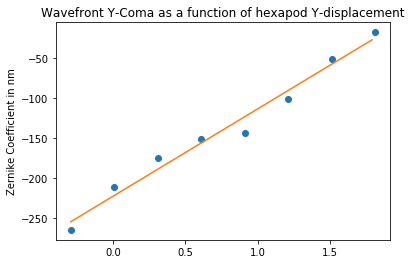

[-222.86687309  109.58847658]


In [58]:
inds = np.arange(0,10) # drop the last value
inds = [0,1,2,3,5,6,7,8]


xdata=df3['y'][inds]
ydata=df3['zern_ycoma_nm'][inds]

plt.plot(xdata,ydata,'o')
x=np.arange(np.min(xdata), np.max(xdata), np.abs(np.max(xdata) - np.min(xdata))/100 )
popt,pcov = curve_fit(line, xdata, ydata)
print('Wavefront X-Coma as a function of Hexapod displacement',popt)

plt.plot(x,line(x, *popt))
# plt.xlabel('Hexapod displacement in the plane')
plt.ylabel('Zernike Coefficient in nm')
plt.title('Wavefront Y-Coma as a function of hexapod Y-displacement')
plt.show()

print(popt)

### Plot Defocus as a function of Y-hexapod decentering

Wavefront X-Coma as a function of Hexapod displacement [106.05038291 -78.92412164]


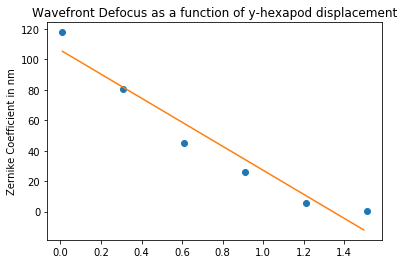

[106.05038291 -78.92412164]


In [30]:
#Coma as a function of x,y offset (8-23, 31-35)
inds = np.arange(0,10)
inds = [0,1,2,3,5,6,7,8]
#inds = [0,1,2,5,6,7]


xdata=df3['y'][inds]
ydata=df3['zern_defocus_nm'][inds]

plt.plot(xdata,ydata,'o')
x=np.arange(np.min(xdata), np.max(xdata), np.abs(np.max(xdata) - np.min(xdata))/100 )
popt,pcov = curve_fit(line, xdata, ydata)
print('Wavefront X-Coma as a function of Hexapod displacement',popt)

plt.plot(x,line(x, *popt))
# plt.xlabel('Hexapod displacement in the plane')
plt.ylabel('Zernike Coefficient in nm')
plt.title('Wavefront Defocus as a function of y-hexapod displacement')
plt.show()

print(popt)